In [1]:
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import pandas as pd
import librosa.display
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
Ravdess = "audio_speech_actors_01-24/"
Tess = "TESS Toronto emotional speech set data/"

In [3]:
import os
rd = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in rd:
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
print(emotion_df)
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()


      Emotions
0            1
1            1
2            1
3            1
4            2
...        ...
1435         8
1436         8
1437         8
1438         8
1439         8

[1440 rows x 1 columns]


,Emotions,Path
0,neutral,audio_speech_actors_01-24/Actor_01/03-01-01-01...
1,neutral,audio_speech_actors_01-24/Actor_01/03-01-01-01...
2,neutral,audio_speech_actors_01-24/Actor_01/03-01-01-01...
3,neutral,audio_speech_actors_01-24/Actor_01/03-01-01-01...
4,calm,audio_speech_actors_01-24/Actor_01/03-01-02-01...


In [4]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

,Emotions,Path
0,angry,TESS Toronto emotional speech set data/OAF_ang...
1,angry,TESS Toronto emotional speech set data/OAF_ang...
2,angry,TESS Toronto emotional speech set data/OAF_ang...
3,angry,TESS Toronto emotional speech set data/OAF_ang...
4,angry,TESS Toronto emotional speech set data/OAF_ang...


In [5]:
full_df = pd.concat([Ravdess_df, Tess_df], axis = 0)
full_df.to_csv("full_df.csv",index=False)
full_df.head()

,Emotions,Path
0,neutral,audio_speech_actors_01-24/Actor_01/03-01-01-01...
1,neutral,audio_speech_actors_01-24/Actor_01/03-01-01-01...
2,neutral,audio_speech_actors_01-24/Actor_01/03-01-01-01...
3,neutral,audio_speech_actors_01-24/Actor_01/03-01-01-01...
4,calm,audio_speech_actors_01-24/Actor_01/03-01-02-01...


In [6]:
data_count=full_df.groupby(['Emotions'])['Emotions'].count()
print(data_count)

Emotions
angry       592
calm        192
disgust     592
fear        592
happy       592
neutral     496
sad         592
surprise    592
Name: Emotions, dtype: int64


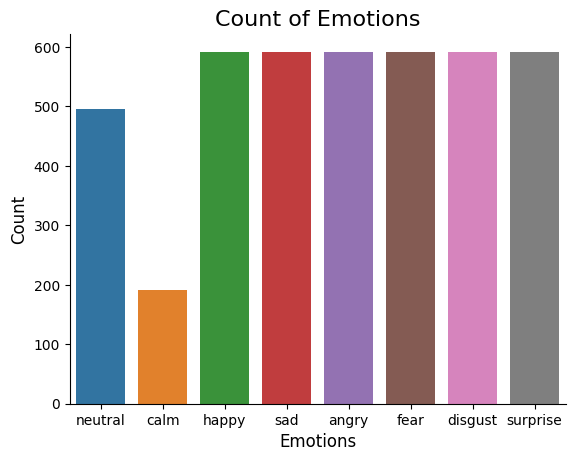

In [7]:
plt.title('Count of Emotions', size=16)
sns.countplot(x='Emotions',data=full_df)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
8


<AxesSubplot:xlabel='Emotions', ylabel='count'>

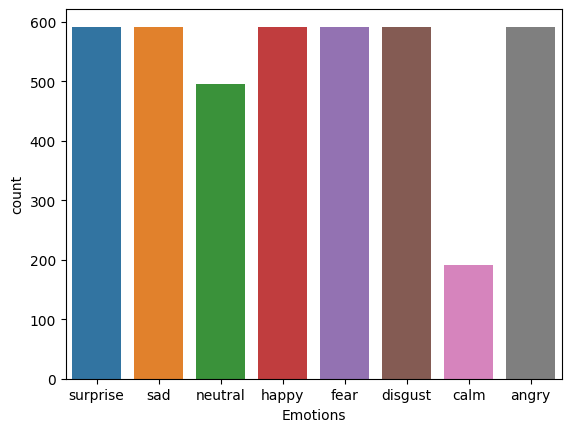

In [8]:
df_modified=full_df.groupby("Emotions").filter(lambda x: len(x) >= 192).sort_values(by='Emotions',ascending=False)
l=list(df_modified.groupby("Emotions").groups)
print(l)
print(len(l))
sns.countplot(data=df_modified,x='Emotions')

      Emotions                                               Path
29       angry  audio_speech_actors_01-24/Actor_01/03-01-05-01...
574      angry  audio_speech_actors_01-24/Actor_10/03-01-05-02...
106      angry  TESS Toronto emotional speech set data/OAF_ang...
172      angry  TESS Toronto emotional speech set data/OAF_ang...
1048     angry  audio_speech_actors_01-24/Actor_18/03-01-05-01...
...        ...                                                ...
2579  surprise  TESS Toronto emotional speech set data/YAF_ple...
1132  surprise  audio_speech_actors_01-24/Actor_19/03-01-08-01...
1073  surprise  audio_speech_actors_01-24/Actor_18/03-01-08-01...
834   surprise  audio_speech_actors_01-24/Actor_14/03-01-08-01...
1197  surprise  audio_speech_actors_01-24/Actor_20/03-01-08-02...

[1536 rows x 2 columns]


<AxesSubplot:xlabel='Emotions', ylabel='count'>

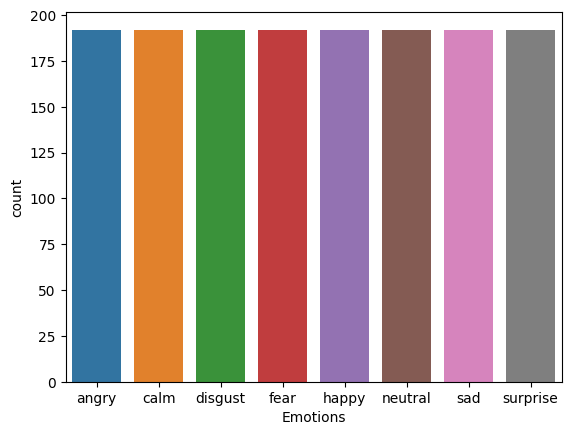

In [9]:
df_final=df_modified.groupby('Emotions').sample(n=192,random_state=170,replace=False)
print(df_final)
sns.countplot(data=df_final,x="Emotions")

In [10]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(' {} emotion waveplot'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('{} emotion spectrogram'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

TESS Toronto emotional speech set data/YAF_sad/YAF_thought_sad.wav


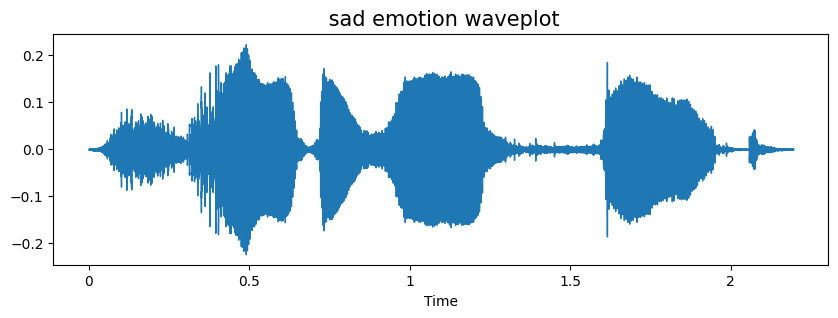

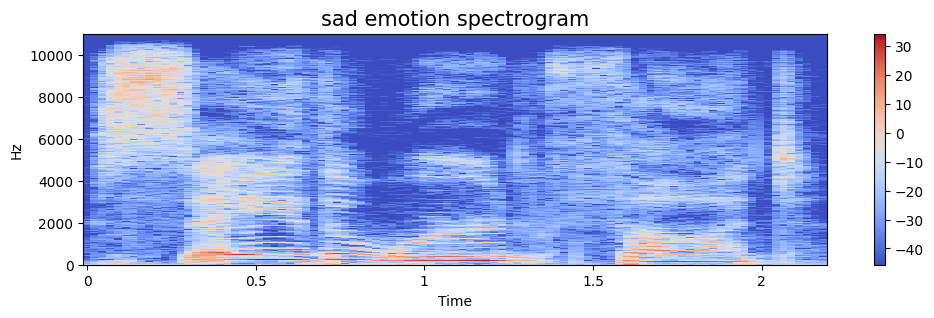

In [11]:
import numpy as np
emotion='sad'
path = np.array(df_final.Path[df_final.Emotions==emotion])[1]
print(path)
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [12]:
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def addnoise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data


def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
path = np.array(df_final.Path)[1]
data, sample_rate = librosa.load(path)

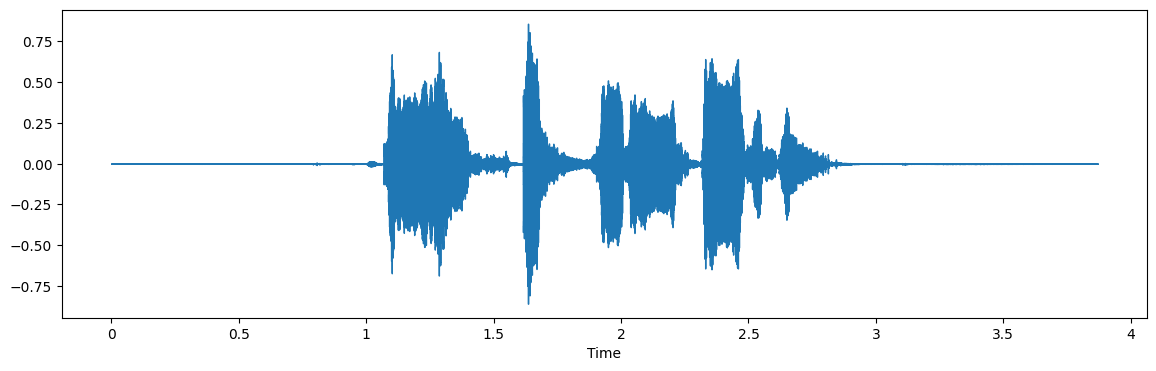

In [13]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

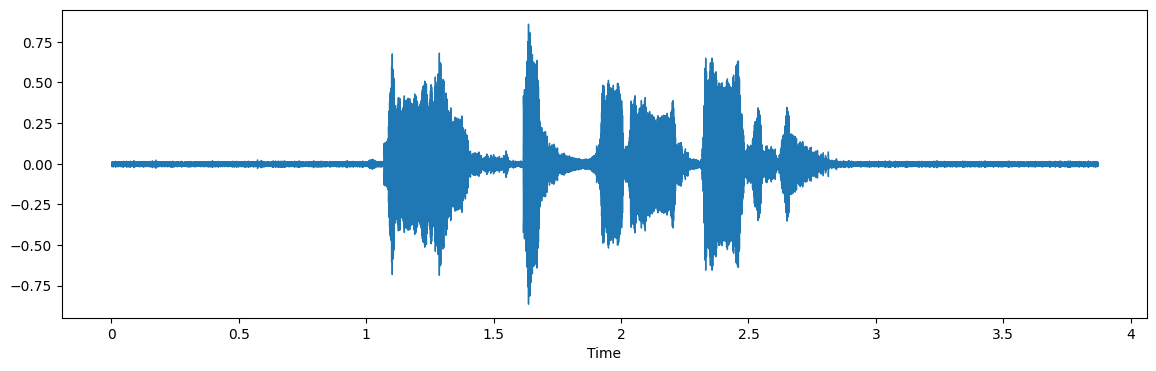

In [14]:
x = addnoise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

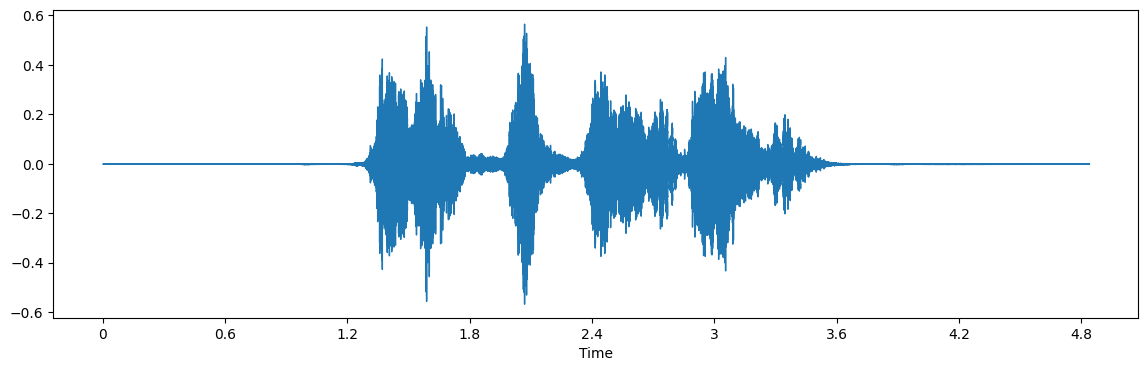

In [15]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

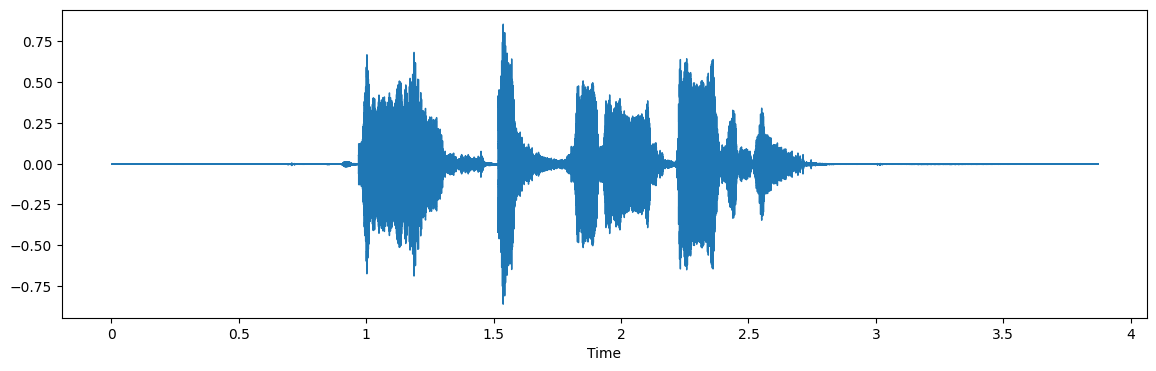

In [16]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [17]:
def fe(data):
    features = np.array([])
    s=librosa.feature.zero_crossing_rate(y=data).T
    zcr = np.mean(s, axis=0)
    features=np.hstack((features, zcr))
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    features = np.hstack((features, chroma_stft))
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    features = np.hstack((features, mfcc))
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    features = np.hstack((features, rms))
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    features= np.hstack((features, mel))
    return features

def fg(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    f1 = fe(data)
    features = np.array(f1)
    ns = addnoise(data)
    f2 = fe(ns)
    features = np.vstack((features, f2))
    new_data = stretch(data)
    sp = pitch(new_data, sample_rate)
    f3 = fe(sp)
    features = np.vstack((features, f3)) 
    return features

In [18]:
X,Y = [],[]
for path, emotion in zip(df_final.Path, df_final.Emotions):
    feature = fg(path)
    for i in feature:
        X.append(i)
        Y.append(emotion)

In [19]:
len(X), len(Y), df_final.Path.shape

(4608, 4608, (1536,))

In [20]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.174778,0.620475,0.685482,0.676212,0.655142,0.665191,0.662599,0.641046,0.643791,0.604673,...,0.000578,0.000349,0.000488,0.000851,0.000789,0.000564,0.000134,0.000010,1.594725e-07,angry
1,0.268387,0.714198,0.782868,0.773267,0.754295,0.766496,0.722868,0.657940,0.651398,0.630121,...,0.001253,0.001056,0.001245,0.001590,0.001515,0.001308,0.000836,0.000703,6.840552e-04,angry
2,0.171083,0.574481,0.613020,0.665708,0.630025,0.649986,0.648978,0.661724,0.638862,0.611759,...,0.000253,0.000129,0.000093,0.000110,0.000114,0.000108,0.000026,0.000002,9.349698e-09,angry
3,0.157353,0.524553,0.511956,0.506665,0.583160,0.603156,0.593577,0.571747,0.596435,0.667272,...,0.006279,0.006175,0.005874,0.006055,0.006954,0.008089,0.003377,0.000424,5.768819e-06,angry
4,0.192342,0.540267,0.521326,0.559495,0.618721,0.622439,0.586158,0.556518,0.620224,0.662019,...,0.006286,0.006174,0.005872,0.006054,0.006954,0.008092,0.003375,0.000424,6.645829e-06,angry


In [21]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3456, 162), (3456, 8), (1152, 162), (1152, 8))

In [23]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3456, 162), (3456, 8), (1152, 162), (1152, 8))

In [24]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3456, 162, 1), (3456, 8), (1152, 162, 1), (1152, 8))

In [25]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu',input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'rmsprop' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0

In [26]:
training1 = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[training1])

Epoch 1/50
54/54 [==============================] - 7s 112ms/step - loss: 1.8882 - accuracy: 0.2749 - val_loss: 1.5628 - val_accuracy: 0.4696 - lr: 0.0010
Epoch 2/50
54/54 [==============================] - 5s 95ms/step - loss: 1.5355 - accuracy: 0.4592 - val_loss: 1.2705 - val_accuracy: 0.5773 - lr: 0.0010
Epoch 3/50
54/54 [==============================] - 5s 94ms/step - loss: 1.3324 - accuracy: 0.5373 - val_loss: 1.0825 - val_accuracy: 0.6424 - lr: 0.0010
Epoch 4/50
54/54 [==============================] - 5s 91ms/step - loss: 1.1546 - accuracy: 0.6036 - val_loss: 1.0616 - val_accuracy: 0.6293 - lr: 0.0010
Epoch 5/50
54/54 [==============================] - 5s 91ms/step - loss: 1.0831 - accuracy: 0.6296 - val_loss: 0.8857 - val_accuracy: 0.7109 - lr: 0.0010
Epoch 6/50
54/54 [==============================] - 5s 91ms/step - loss: 1.0036 - accuracy: 0.6591 - val_loss: 0.8387 - val_accuracy: 0.7248 - lr: 0.0010
Epoch 7/50
54/54 [==============================] - 5s 92ms/step - loss: 0.

36/36 [==============================] - 1s 14ms/step - loss: 0.6306 - accuracy: 0.8715
Accuracy of our model on test data :  87.15277910232544 %


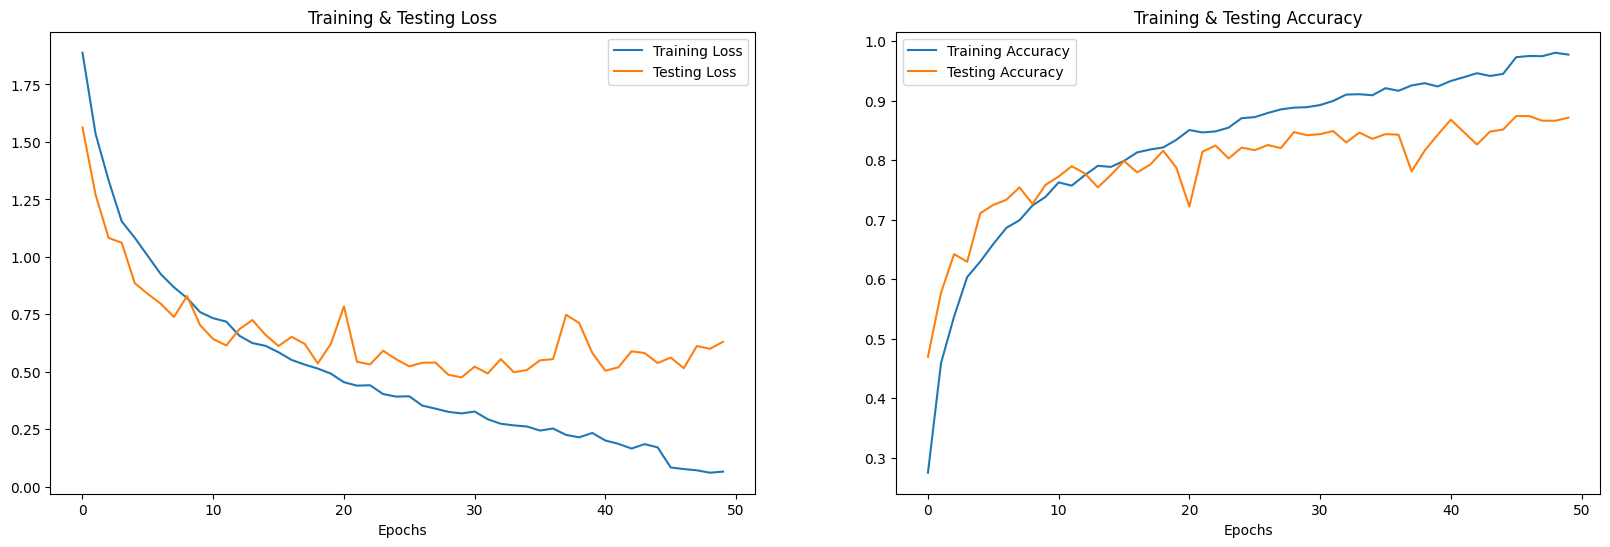

In [27]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [28]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

36/36 [==============================] - 1s 13ms/step


In [29]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,surprise,surprise
1,happy,happy
2,happy,happy
3,calm,sad
4,angry,angry
5,sad,sad
6,surprise,surprise
7,angry,angry
8,calm,calm
9,disgust,disgust


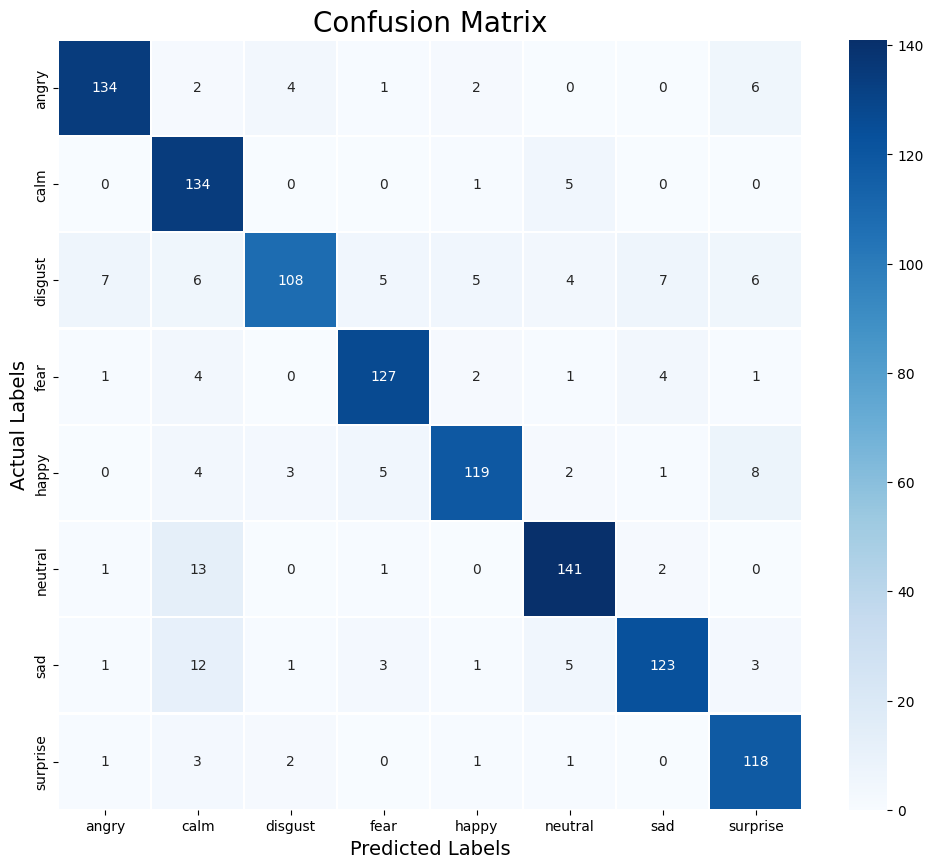

In [30]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.92      0.90      0.91       149
        calm       0.75      0.96      0.84       140
     disgust       0.92      0.73      0.81       148
        fear       0.89      0.91      0.90       140
       happy       0.91      0.84      0.87       142
     neutral       0.89      0.89      0.89       158
         sad       0.90      0.83      0.86       149
    surprise       0.83      0.94      0.88       126

    accuracy                           0.87      1152
   macro avg       0.88      0.87      0.87      1152
weighted avg       0.88      0.87      0.87      1152

